# Lipkin Model
#### Kris McBrian
***
Hamiltonian in Quasispin Formalism      
$H = \epsilon J_z - \frac{1}{2} V(J^2_+ + J_-^2) $

In [2]:
import numpy  as np
import matplotlib.pyplot as plt
import qiskit as qk
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram


backend = qk.Aer.get_backend('qasm_simulator')

#### Numerically solve Lipkin model using matrix elements

In [3]:
def diag_lipkin(N,e,V):
    j_max = float(N)/2
    j = np.array([j_max])#np.arange(0.5,j_max+1,1.0) # array of all j values

    for i in range(j.size):
        m = np.arange(-j[i],j[i]+1,1.0)
        H = np.zeros((m.size,m.size))
        for i_m in range(m.size):
            H[i_m][i_m] =  e * m[i_m] 
            if(i_m+2<m.size): # (J_+)**2 term from quasispin H
                H[i_m][i_m+2] = -V/2. * np.sqrt(j[i]*(j[i]+1)-(m[i_m]*(m[i_m]+1)))
                H[i_m][i_m+2] *= np.sqrt(j[i]*(j[i]+1)-((m[i_m]+1)*(m[i_m]+2)))
            if(i_m-2>=0):# (J_-)**2
                H[i_m][i_m-2] = -V/2. * np.sqrt(j[i]*(j[i]+1)-(m[i_m]*(m[i_m]-1)))
                H[i_m][i_m-2] *= np.sqrt(j[i]*(j[i]+1)-((m[i_m]-1)*(m[i_m]-2)))
                    
    return np.linalg.eigvalsh(H)

#### Parity projected mean-field

In [4]:
# Parity Projection
def parity_proj(theta,arg):
    #parity either +1 or -1
    N=arg[0]
    e=arg[1]
    V=arg[2]
    parity=arg[3]
    a = -N*e/2 * (np.cos(2*theta) + (N-1)*V/(2*e) * np.sin(2*theta)**2)
    return a * (1 + parity*np.cos(2*theta)**(N-2))/(1 + parity*np.cos(2*theta)**N)

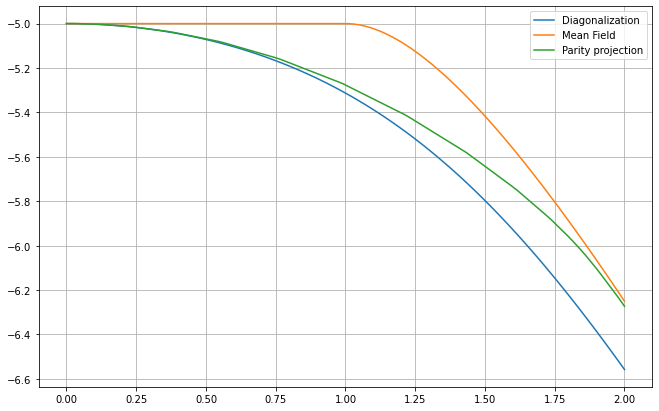

In [7]:
# system parameters
N = 10
e = 1

num_val = 100
chi = np.linspace(0,2,num_val)
V = chi*e/float(N-1)

diag_result = np.zeros(num_val)
exac_result = np.zeros(num_val)
pari_result = np.zeros(num_val)
temp_result = np.zeros(num_val)
temp = np.zeros(num_val)

theta = np.linspace(0,np.pi,num_val)


for i in range(num_val):
    diag_result[i] = diag_lipkin(N,e,V[i])[0] # Diagonalization
    exac_result[i] = -N*e/2. if chi[i]<1 else -N*e/4. * (chi[i] + 1/chi[i]) # mean field: eqn (20)
    for j in range(num_val):
        # Find minimum of parity projected mean field
        temp[j] = parity_proj(theta[j],[N,e,V[i],+1])
    pari_result[i] = np.min(temp)

plt.figure(figsize = (11,7))
plt.plot(chi,diag_result,label="Diagonalization")
plt.plot(chi,exac_result,label="Mean Field")
plt.plot(chi,pari_result, label="Parity projection")
plt.legend(loc='best')
plt.grid()
plt.show()

#### Generator Coordinate Function

In [6]:
num_val = 50 
N = 10
e = 1
chi = np.linspace(0,2,num_val)
N_grid = np.zeros((num_val,num_val))
H_grid = np.ones((num_val,num_val)) * -N*e/2.
theta = np.linspace(0,np.pi,num_val)
for i in range(num_val):
    for j in range(num_val):
        N_grid[i,j] = np.cos(theta[i]-theta[j])**N
        H_grid[i,j] *= np.cos(theta[i]-theta[j])**(N-2) * (np.cos(theta[i]-theta[j]) * np.cos(theta[i]+theta[j]) + CHI(np.cos(theta[i])**2 * np.sin(theta[j])**2 + np.cos(theta[j])**2 * np.sin(theta[i])**2)) 


NameError: name 'CHI' is not defined

In [33]:
# circuit parameters
n_angles = 100
n_shots = 2**13 # number of measurements of quantum circuit

# system parameters
N = 10
e = 1

num_val = 30
chi = np.linspace(0,2,num_val)
V = chi*e/float(N-1)


#### Mean Field Quantum Circuits

In [34]:
# Hamiltonian
def H(e, V, Jz, JpJm):
    return e*Jz - 0.5*V*JpJm

# evaluate expectation value from results of circuits
def exp_value(eig_val, results, n_shots):
    avg = 0.
    # for every result that was measured
    for a in results.keys():
        # obtain index by converting binary measurement to integer
        b = int(a,2)    # e.g. '10' eigenvalue stored at index 2 of eig
        # weighted sum of eigenvalues and number of measurments
        avg += eig_val[b]*results[a]
    return avg / n_shots

#### $J_z$ Functions

In [35]:
def Jz_circuit(theta, n_shots):
    qc = qk.QuantumCircuit(1,1)
    
    qc.ry(2*theta, 0)
    
    qc.measure(0,0)
    
    exp_values = qk.execute(qc, backend, shots=n_shots)
    results = exp_values.result().get_counts()
    return 0.5*exp_value([1.,-1.], results, n_shots)

def Jz_expvalue(theta):
    return 0.5*np.cos(2*theta)

#### $J_+^2 + J_-^2$ Functions

In [36]:
def JpJm_circuit(theta, n_shots):
    qc = qk.QuantumCircuit(2,2)
    
    qc.ry(2*theta, 0)
    qc.ry(2*theta, 1)

    qc.cx(0,1)
    qc.h(0)    
    
    qc.measure(0,0)
    qc.measure(1,1)
    
    exp_val = qk.execute(qc, backend, shots=n_shots)
    results = exp_val.result().get_counts()
    return exp_value([1.,-1.,0,0], results, n_shots)

def JpJm_expvalue(theta):
    return 0.5*(np.sin(2*theta))**2

#### Evaluate Circuits and Exact Expectation Values

In [37]:
theta = np.linspace(0,np.pi,n_angles)
Jz_results = np.zeros(n_angles)
Jz_exact = np.zeros(n_angles)

JpJm_results = np.zeros(n_angles)
JpJm_exact = np.zeros(n_angles)
H_results = np.zeros(n_angles)
H_exact = np.zeros(n_angles)

min_result = np.zeros(num_val)
min_exact = np.zeros(num_val)

for j in range(num_val):
    for i in range(n_angles):
        Jz_results[i] = Jz_circuit(theta[i],n_shots)
        Jz_exact[i] = Jz_expvalue(theta[i])

        JpJm_results[i] = JpJm_circuit(theta[i], n_shots)
        JpJm_exact[i] = JpJm_expvalue(theta[i])
        
    min_result[j] = np.min(H(e,V[j],Jz_results,JpJm_results))
    min_exact[j] = np.min(H(e,V[j],Jz_exact,JpJm_exact))

Trying to recreate plot from above using the mean field quantum circuit.
Still a work in progress

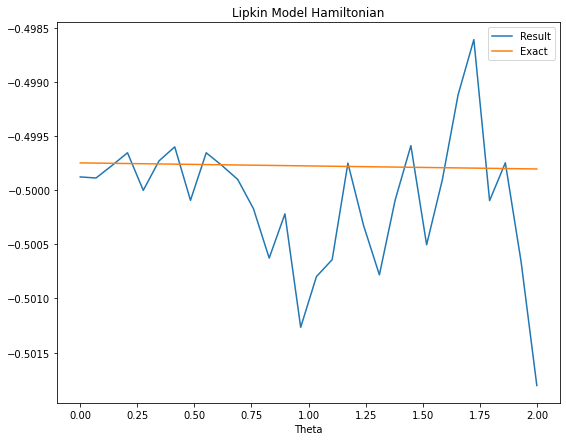

In [38]:
plt.figure(figsize = (9,7))
#plt.plot(theta,e*Jz_results - 0.5*V*JpJm_results,label='Results')
#plt.plot(theta,H(e, V, Jz_results, JpJm_results),label='Results')
#plt.plot(theta,H(e, V, Jz_exact, JpJm_exact),label='Exact')
plt.plot(chi, min_result,label="Result")
plt.plot(chi, min_exact, label="Exact")
plt.title("Lipkin Model Hamiltonian")
plt.xlabel("Theta")
plt.legend()
plt.show()